# Plot GEBCO bathymetry and mask for the All European Seas domain

In [31]:
using DIVAnd
using ColorSchemes
using NCDatasets
using GeoDatasets
using CairoMakie, GeoMakie
using GeometryOps, GeoInterface
using JupyterFormatter
enable_autoformat()
include("./config.jl")

edit_mask!

In [3]:
topodir = "/home/ctroupin/data/GEBCO/"
topofile = joinpath(topodir, "gebco_30sec_16.nc")
bx, by, b = DIVAnd.extract_bath(topofile, true, lonr, latr)
b[b.<0.0] .= NaN;

lon_landsea, lat_landsea, landsea = GeoDatasets.landseamask(; resolution = 'i', grid = 5)
landsea[landsea.==2] .= 1;

In [4]:
xi, yi, mask = load_mask(topofile, true, lonr, latr, 0.0);
coordinatelist = read_polygon_json("./mask.json");
edit_mask!(xi, yi, mask, coordinatelist)

## Make the plot

In [24]:
cmap = cgrad(:deep)

fig = Figure(size = (600, 600))
ga = GeoAxis(
    fig[1, 1],
    title = "GEBCO bathymetry and land-sea mask\nfor the All European Seas domain",
    dest = "+proj=ortho +lon_0=15 +lat_0=35",
)
heatmap!(
    ga,
    lon_landsea,
    lat_landsea,
    landsea,
    colormap = Reverse(:greys),
    colorrange = [0, 2],
)
hm = heatmap!(
    ga,
    bx,
    by,
    b,
    colormap = cmap,
    colorrange = (0, 6000.0),
    highclip = cmap.colors[end],
)
masklayer = contourf!(xi, yi, mask, levels = [0.0, 0.0001], colormap = Reverse(:binary))

xlims!(ga, -180, 180.0)
ylims!(ga, -90.0, 90.0)
hidedecorations!(ga)
Colorbar(fig[1, 2], hm, label = "m", labelrotation = 0)
save(joinpath(figdir, "gebco_bathy_mask2.png"), fig)
# fig

CairoMakie.Screen{IMAGE}


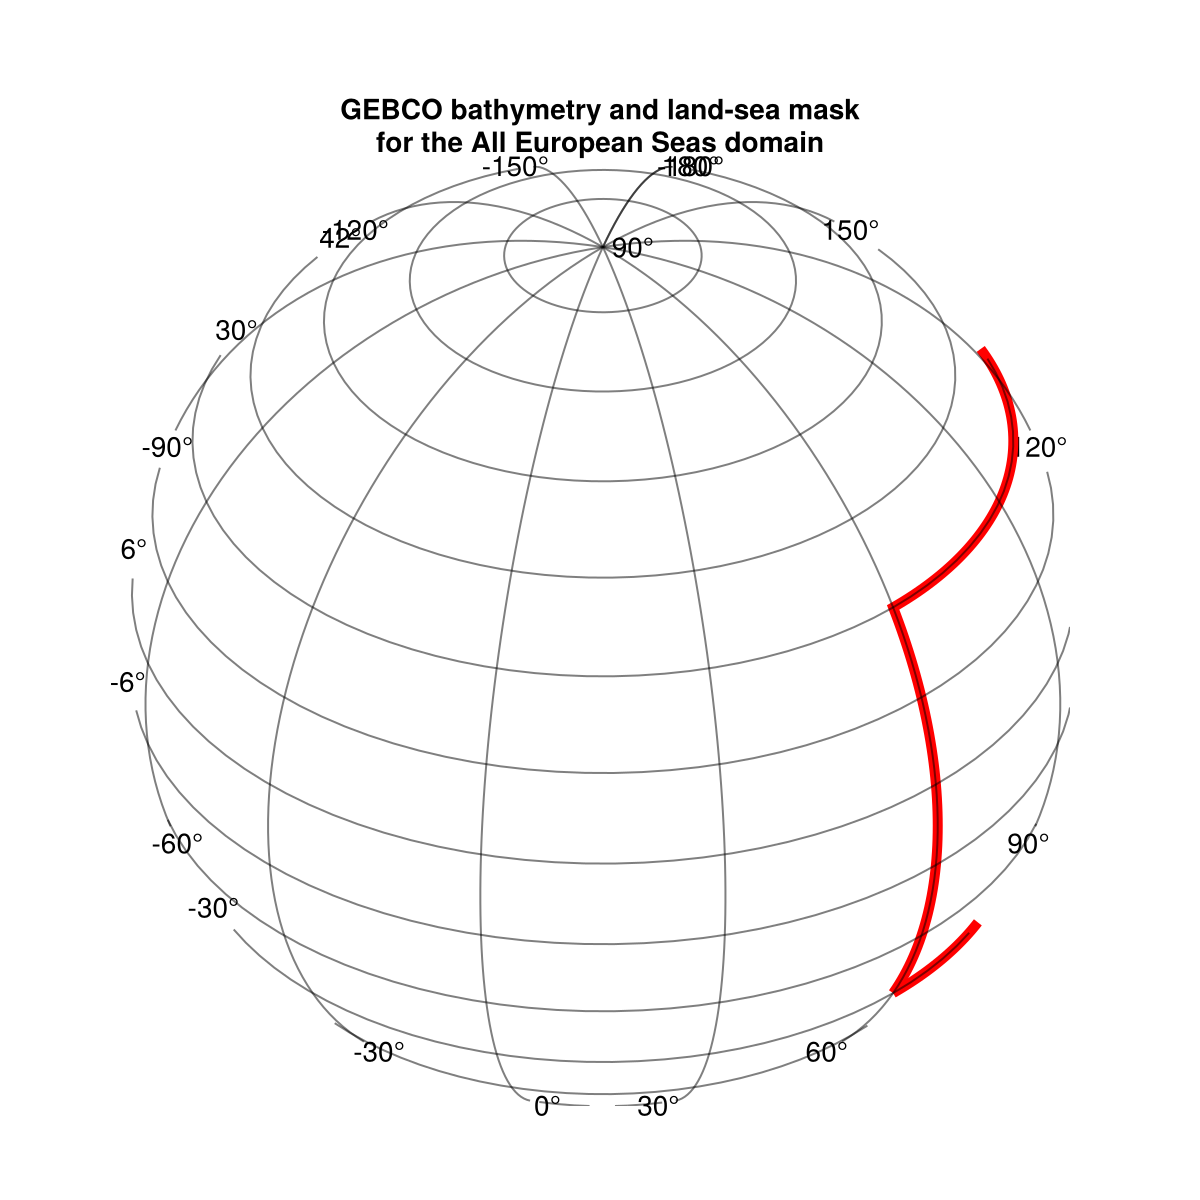

In [37]:
fig = Figure(size = (600, 600))
ga = GeoAxis(
    fig[1, 1],
    title = "GEBCO bathymetry and land-sea mask\nfor the All European Seas domain",
    dest = "+proj=ortho +lon_0=15 +lat_0=35",
)
poly = GeoInterface.LineString([(60, -30), (180, -30), (180, 30), (60, 30), (60, -30)])
spoly = GeometryOps.segmentize(poly, max_distance = 1)
lines!(ga, GeoMakie.geo2basic(spoly), color = :red, linewidth = 5)
xlims!(ga, -180, 180.0)
ylims!(ga, -90.0, 90.0)
fig

GeoInterface.Wrappers.LineString{false, false}([(60, -30), (180, -30), … (1) … , (60, 30)])

GeoInterface.Wrappers.LineString{false, false}([(60.0, -30.0), … (299) … , (60.0, 30.0)])